<a href="https://colab.research.google.com/github/Likelipop/see_AI/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
1. Chương trình báo lỗi ở rất nhiều dòng, dữ dằn nhất là trật indentation.

2. Áp dụng và triển khai em có để code ở bên dưới ạ

3. Thuật toán chạy ra kết quả sai, và những chỗ bug em tìm được chi tiết trình bày trong phần thân báo cáo (kể cả những chỗ "#gotcha" trong code)

#Clone dữ liệu từ github về

In [3]:
!git clone "https://github.com/Likelipop/see_AI.git"

Cloning into 'see_AI'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [5]:
%cd "/content/see_AI"

/content/see_AI


#Thêm các thư viện cần thiết

In [8]:
from matplotlib import pyplot as plt
from collections import defaultdict
from queue import PriorityQueue
import math

# Tạo lớp Point

Lớp Point nắm giữ các thông tin về:
* Tọa độ của điểm
* ID của Đa giác mà điểm thuộc về
* Nút cha của điểm hiện tại khi duyệt


In [9]:
class Point(object):
    def __init__(self, x, y, polygon_id = -1):
        self.x = x
        self.y = y
        self. g =0
        self.polygon_id = polygon_id
        self.pre = None

    def rel(self, other, line):
        return line.d(self) * line.d(other) >= 0

    def can_see(self, other, line):
        l1 = self.line_to(line.p1)
        l2 = self.line_to(line.p2)
        d3 = line.d(self) * line.d(other) < 0
        d1 = other.rel(line.p2,l1)
        d2 = other.rel(line.p1,l2)
        return not (d1 and d2 and d3)

    def line_to(self,other):
        return Edge(self, other)

    def heuristic(self, other):
        return euclid_distance(self, other)

    def __eq__(self, point):
        return point and self.x == point.x and self.y == point.y

    def __ne__(self, point):
        return not self.__eq__(point)

    def __hash__(self):
        return self.x.__hash__() ^ self.y.__hash__()

    def __lt__(self, point):
        return hash(self) < hash(point)

    def __str__(self):
        return "(%d, %d)" % (self.x, self.y)

    def __repr(self):
        return "(%d, %d)" % (self.x, self.y)

# Xây dựng lớp Edge
Lớp này lưu giữ thông tin về cạnh (thành phần bao gồm 2 điểm), đồng thời chứa các phương thức liên quan như:
* Lấy mút còn lại của cạnh
* Tính khoảng cách của đường thằng từ điểm cho trước

In [10]:
class Edge(object):
    def __init__(self, point1, point2):
        self.p1 = point1
        self.p2 = point2

    def get_adjacent(self, point):
        if point == self.p1:
            return self.p2
        if point == self.p2:
            return self.p1


    def d (self, point):
        vect_a = Point(self.p2.x - self.p1.x, self.p2.y - self.p1.y)
        vect_n = Point(-vect_a.y, vect_a.x)
        return vect_n.x * (point.x - self.p1.x) + vect_n.y*(point.y - self.p1.y)

    def __str__(self):
        return "({},{})".format(self.p1, self.p2)

    def __contains__ (self, point):
        return self.p1 == point or self.p2 == point

    def __hash__(self):
        return self.p1.__hash__() ^self.p2.__hash__()


    def __repr_(self):
        return "Edge({!r}, {!r})".format(self.p1, self.p2)


# Xây dựng lớp Graph

Lớp này dùng để chứa các thông tin quan trọng trong bài toán cho quá trình duyệt, bao gồm:
1. Từ điển Graph: Cái này dùng để lưu một từ điển có dạng STT: Poygons,
trong đó polygons là một tập tuần tự các điểm của một đa giác. Tuy nhiên trong Graph này chứa 2 polygons đặt biệt, đó chính là điểm bắt đầu và điểm xuất phát. (*)
2.  Tập các cạnh: cái này dùng để lưu lại tập các cạnh mà bài toán đang có. Tập này đóng vai trò chính trong việc tìm kiếm các điểm có thể thấy được trong lúc duyệt.
3. Từ điển Polygons: Tập này dùng để chứa các đa giác có trong bài toán, có dạng STT: danh sách các cạnh của đa giác. Đây cũng đóng vai trò trong việc tìm kiếm lân cận (các đỉnh thấy được) của đỉnh trong lúc duyệt.

Đồng thời, lớp còn chứa các hàm phụ trợ khác cho các thuật toán duyệt:
1. get_adjacent_points(self, point) : lấy điểm lân cận của point trên cùng một đa giác
2. h(self, point): trả về giá trị ước lượng của point tới goal theo đường chim bay.
3. can_see(self, start): hàm này trả về danh sách các điểm mà start có thể "nhìn thấy được"


---

**Hàm này lúc đầu trong file code có lỗi !!!**
1. Indentaion Trậc từ line 67 đến line 74 trong code dưới
2. Ngoài ra trong code cũng có trật indetation khá nhiều (thậm chí là làm cho code lỗi), tuy nhiên em nghĩ có thể là do lỗi từ file nên em đã tinh chỉnh lại cho đúng ý code.





In [11]:
class Graph:
    def __init__(self, polygons):

        self.graph = defaultdict(set)
        self.edges = set()
        self.polygons = defaultdict(set)
        pid =0
        for polygon in polygons:

            # incase of line.
            if len(polygon) == 2:
                polygons.pop()

            # incase just  a  polygon ?
            if polygon[0] == polygon[-1]:
                self.add_point(polygon[0])
            else:
                for i, point in enumerate(polygon):
                    #Create edge


                    neighbor_point = polygon[(i+1) % len(polygon)]
                    #print(f" {point} - {neighbor_point}#", end = " " )
                    edge = Edge(point, neighbor_point)

                    #If not a 1d polygon
                    if len(polygon) > 2:
                        point.polygon_id = pid
                        self.polygons[pid].add(edge)

                    self.add_edge(edge)

                if len(polygon) > 2:
                    pid+=1

    def display (self):
        for items in self.graph.items:
            for eachitems in items :
                print(eachitems, end = " ")
            print()


    def get_adjacent_points(self, point): # ??
        return list(filter(None, [edge.get_adjacent(point) for edge in self.edges]))

    def can_see(self, start):
        see_list = list()
        cant_see_list = list()

        for polygon in self.polygons:
            for edge in self.polygons[polygon]:
                for point in self.get_points():
                    if start == point:
                        cant_see_list.append(point)

                    #the pin node lies in current polygons
                    if start in self.get_polygon_points(polygon):

                        for poly_point in self.get_polygon_points(polygon):
                            if poly_point not in self.get_adjacent_points(start):
                                cant_see_list.append(poly_point)
                                if poly_point in see_list:
                                    see_list.remove(poly_point)

                    # the point is outside the current polygon & not in start.
                    if point not in cant_see_list: # see yah too (indetaion 145-149)
                        if start.can_see(point, edge):
                            if point not in see_list:     # this one indentation
                                see_list.append(point)
                        elif point in see_list:
                            see_list.remove(point)
                            cant_see_list.append(point)
                        else:
                            cant_see_list.append(point)

        return see_list
    def h(self, point):
        heuristic = getattr(self, 'heuristic', None)
        if heuristic:
            return heuristic[point]
        else:
            return -1


    def get_polygon_points(self, index):
        point_set = set()
        for edge in self.polygons[index]:
            point_set.add(edge.p1)
            point_set.add(edge.p2)
        return point_set

    def get_points (self):
        return list(self.graph)

    def get_edges(self):
        return self.edges

    def add_point(self, point):
        self.graph[point].add(point)

    def add_edge(self, edge):
        self.graph[edge.p1].add(edge)
        self.graph[edge.p2].add(edge)
        self.edges.add(edge)

    def __contains__ (self, item):
        if isinstance(item, Point):
            return item in self.graph
        if isinstance(item, Edge):
            return item in self.edges
        return False

    def __getitem__(self, point):
        if point in self.graph:
            return self.graph[point]
        return set()

    def __str__(self):
        res= ""
        for point in self.graph:
            res+= "\n" + str(point) + ": "
            for edge in self.graph[point]:
                res+= str(edge)
        return res


# Xây dựng hàm ước lượng chi phí

ta viếc một hàm lambda để ước lượng chi phí của node trong lúc duyệt, gồm một ước lượng cho a_star và một ước lượng cho greedy. Do cả hai thuật toán này chỉ khác nhau mỗi hàm ước lượng nên ta có thể viết ra hai hàm chi phí này để luân phiên xử dụng trong hàm search

In [12]:
a_star = lambda graph, i : i.g + graph.h(i)
greedy = lambda graph, i : graph.h(i)

In [13]:
def euclid_distance(point1, point2):
    return round(float(math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)),3)

def search( graph, start, goal, func):
    closed = set()
    queue = PriorityQueue()
    queue.put((0 + func(graph, start), start ))

    #meaningless
    if start not in closed:
        closed.add(start)

    while not queue.empty():
        cost, node = queue.get()
        if node == goal:
            return node

        if node == Point(34,7):
            for item in closed:
                print(item, " ")
        for i in graph.can_see(node):
            if (node == Point(34,7)):
                print(i, end = " ")
            new_cost = node.g + euclid_distance(node, i)
            if i not in closed or new_cost < i.g:
                closed.add(i)
                i.g = new_cost
                i.pre = node
                new_cost = func(graph,i)
                queue.put((new_cost,i))

    return node

# Nhân vật chính
Bao gồm các công việc:
1. Đọc dữ liệu
2. Tổ chức đồ thị từ thông tin đã đọc
3. thực thi tìm kiếm
4. plot đồ thị minh họa


---

**Hàm này lúc đầu cũng nhiều lỗi không kém !!!**

Thiếu dòng này nên thuật toán ban đầu không tìm được đích đến.
```` python
poly_list.append([goal])
````

Đồng thời, trong lúc plot thì đoạn code đã chừa một đa giác cuối cùng ở lại
````python
for i in range(1, len(poly_list) -1 ):
````
Phương án thay thế chỉ đơn giản là bỏ -1 ra khỏi đoạn code trên.

[<__main__.Point object at 0x7ec207817b50>, -1] -> [<__main__.Point object at 0x7ec207816f50>, 1] -> [<__main__.Point object at 0x7ec207815e10>, 1] -> [<__main__.Point object at 0x7ec207817af0>, 3] -> [<__main__.Point object at 0x7ec207816560>, -1]


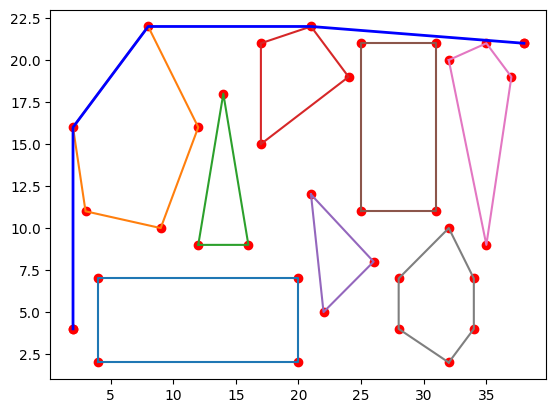

In [14]:
def main():
    n_polygon = 0
    poly_list = list(list())
    x= list()
    y= list()
    with open('Input.txt','r') as f:

        # read every single line and convert its type into int.
        line = f.readline()
        line = line.strip()
        line = line.split()
        line = list(map(int, line))

        # take the number of polygons, the start coord and goal coord.
        n_polygon = line[0]
        start = Point(line[1], line[2])
        goal = Point(line[3], line[4])
        poly_list.append([start]) # end ?

        #for those polygons below.
        for line in f:

            #a list of polygon's vertex
            point_list = list()
            line = line.split()
            n_vertex= int(line[0])

            #keys in evrey node''s coord.
            for j in range(0, 2*n_vertex, 2):
                point_list.append(Point(int(line[j+1]) , int(line[j+2])))

            poly_list.append(point_list[:])

        # got cha
        poly_list.append([goal])
        graph = Graph(poly_list)

        graph.heuristic= {point: point.heuristic(goal) for point in graph.get_points()}

        a = search(graph, start, goal, greedy)

        result = list()

        while a:
            result.append(a)
            a = a.pre


        result.reverse()
        print_res = [[point, point.polygon_id] for point in result]
        print(*print_res, sep = ' -> ')
        plt.figure()
        plt.plot([start.x], [start.y], 'ro')
        plt.plot([goal.x], [goal.y],'ro')
        for point in graph.get_points():
            x.append(point.x)
            y.append(point.y)

        plt.plot(x,y,'ro')
        for i in range(1, len(poly_list) ): #see yah (-1)
            coord = list()
            for point in poly_list[i]:
                coord.append([point.x, point.y])
            coord.append(coord[0])
            xs, ys = zip(*coord)
            plt.plot(xs, ys)
        x = list()
        y = list()
        for point in result:
            x.append(point.x)
            y.append(point.y)
        plt.plot(x,y,'b', linewidth = 2.0)
        plt.show()

main()
